In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from pathlib import Path

# --- CONFIGURATION ---
# Task Selection
TASK = "daily"  # Change to 'lob' for High-Freq analysis

# Model Registry
# We now include the traditional baselines
MODELS = ["naive", "linear", "sinusoidal", "time2vec", "ctlpe", "alibi"] if TASK == "daily" else \
         ["sinusoidal", "time2vec", "ctlpe", "alibi"]

# Which model is the "Standard" to beat? 
# Usually 'naive' for Volatility, or 'sinusoidal' to compare embeddings.
BASELINE_MODEL = "naive" if TASK == "daily" else None

# Paths
RESULTS_DIR = Path("../results/lob") if TASK == "lob" else Path("../results")
PREFIX = "lob" if TASK == "lob" else "wfv"

# Styling
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15, 6)
# Define specific colors for baselines vs DL models
COLOR_MAP = {
    "naive": "black", "linear": "gray", 
    "sinusoidal": "#1f77b4", "time2vec": "#ff7f0e", 
    "ctlpe": "#2ca02c", "alibi": "#d62728"
}

def load_all_data(models, directory, prefix):
    data_dict = {}
    for m in models:
        path = directory / f"{prefix}_{m}.csv"
        if path.exists():
            data_dict[m] = pd.read_csv(path)
        else:
            print(f"⚠️ Missing file for {m}: {path}")
    return data_dict

data_dict = load_all_data(MODELS, RESULTS_DIR, PREFIX)
print(f"Loaded data for: {list(data_dict.keys())}")

Loaded data for: ['naive', 'linear', 'sinusoidal', 'time2vec', 'ctlpe', 'alibi']


In [93]:
if data_dict:
    metrics_list = []
    
    for model, df in data_dict.items():
        actual = df['actual']
        pred = df['predicted']
        
        mse = ((pred - actual) ** 2).mean()
        mae = (pred - actual).abs().mean()
        
        # IC (Correlation) - Handle constant prediction case (Naive)
        if model == "naive" and pred.nunique() == 1:
            ic = 0.0 # Constant prediction has 0 correlation
        else:
            ic = df[['predicted', 'actual']].corr().iloc[0,1]
            
        metrics_list.append({
            "Model": model.capitalize(),
            "RMSE": np.sqrt(mse),
            "MAE": mae,
            "IC": ic
        })
    
    metrics_df = pd.DataFrame(metrics_list).set_index("Model")
    
    print("\n=== 🏆 FINAL LEADERBOARD ===")
    display(metrics_df.sort_values("RMSE")
            .style.highlight_min(subset=["RMSE", "MAE"], color='green')
            .highlight_max(subset=["IC"], color='green'))


=== 🏆 FINAL LEADERBOARD ===


,RMSE,MAE,IC
Model,,,
Naive,0.002686,0.001422,0.989994
Linear,0.006411,0.004593,0.948847
Sinusoidal,0.007356,0.005257,0.940759
Ctlpe,0.007949,0.006317,0.920778
Time2vec,0.009392,0.007296,0.888804
Alibi,0.013662,0.008471,0.800864


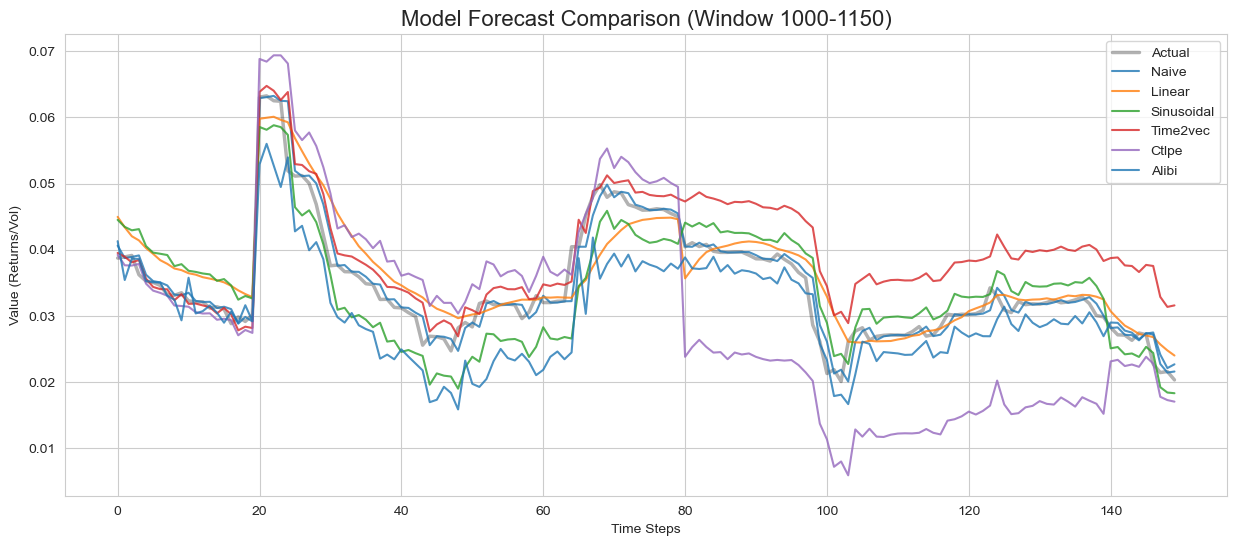

In [94]:
# Select a window (last 100 points or a specific interesting period)
start_idx = 1000
window_size = 150
end_idx = start_idx + window_size

plt.figure(figsize=(15, 6))

# 1. Plot Actual
first_model = list(data_dict.keys())[0]
actual_data = data_dict[first_model].iloc[start_idx:end_idx]['actual'].values
plt.plot(actual_data, label='Actual', color='black', linewidth=2.5, alpha=0.3)

# 2. Plot Each Model
for model in MODELS:
    if model in data_dict:
        pred_data = data_dict[model].iloc[start_idx:end_idx]['predicted'].values
        plt.plot(pred_data, label=model.capitalize(), linewidth=1.5, alpha=0.8)

plt.title(f"Model Forecast Comparison (Window {start_idx}-{end_idx})", fontsize=16)
plt.xlabel("Time Steps")
plt.ylabel("Value (Returns/Vol)")
plt.legend()
plt.show()

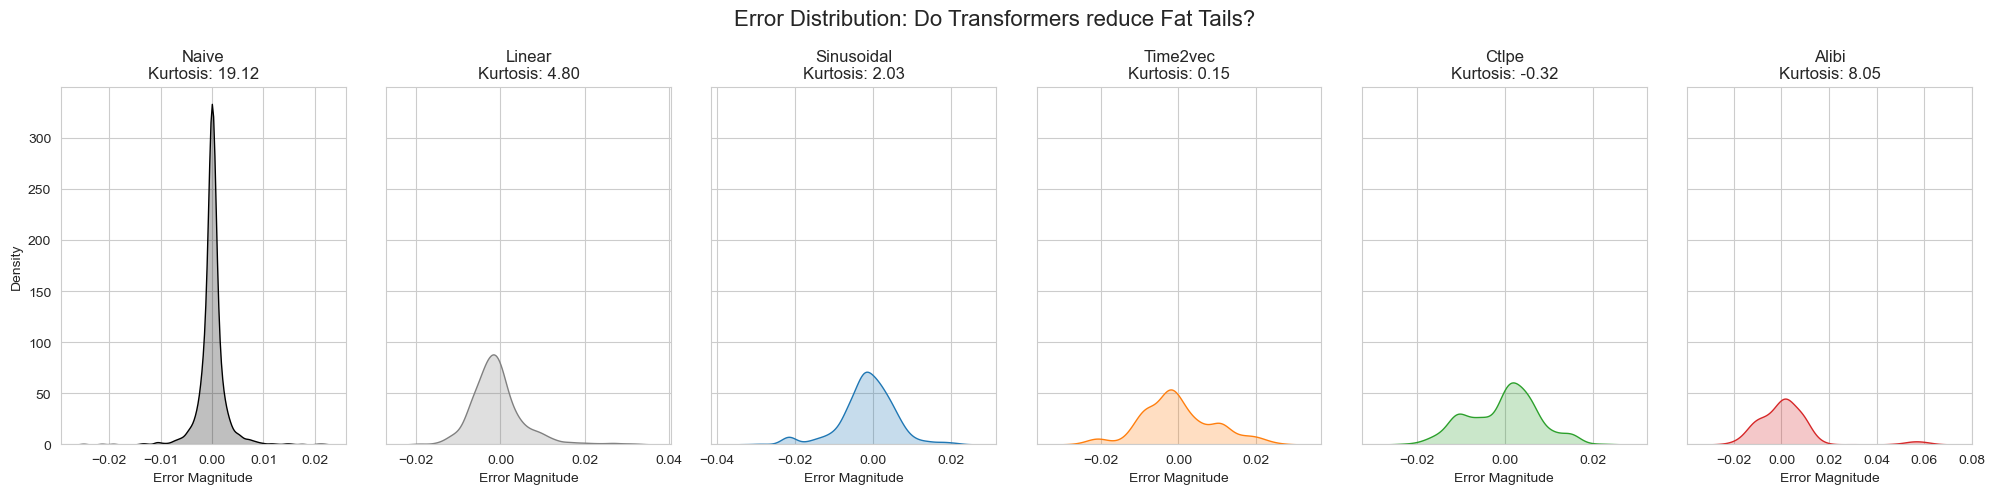

In [95]:
if data_dict:
    # Filter to show only relevant models to save space
    # e.g., Naive, Linear, and your best DL models
    models_to_plot = [m for m in MODELS if m in data_dict]
    
    fig, axes = plt.subplots(1, len(models_to_plot), figsize=(20, 5), sharey=True)
    if len(models_to_plot) == 1: axes = [axes]
    
    for ax, model in zip(axes, models_to_plot):
        df = data_dict[model]
        residuals = df['actual'] - df['predicted']
        
        # Plot Density of Residuals
        sns.kdeplot(residuals, ax=ax, fill=True, color=COLOR_MAP.get(model, 'blue'))
        
        # Annotate Kurtosis (Fat Tails)
        kurt = stats.kurtosis(residuals)
        ax.set_title(f"{model.capitalize()}\nKurtosis: {kurt:.2f}")
        ax.set_xlabel("Error Magnitude")
    
    plt.suptitle(f"Error Distribution: Do Transformers reduce Fat Tails?", fontsize=16)
    plt.tight_layout()
    plt.show()

In [96]:
def diebold_mariano_test(real, pred1, pred2):
    e1 = (real - pred1)**2
    e2 = (real - pred2)**2
    d = e1 - e2
    
    # Handle zero variance (identical predictions)
    if np.std(d) == 0:
        return 0.0, 1.0
        
    dm_stat = np.mean(d) / np.sqrt(np.var(d, ddof=0) / len(d))
    p_value = 2 * (1 - stats.norm.cdf(abs(dm_stat)))
    return dm_stat, p_value

if BASELINE_MODEL in data_dict:
    dm_results = []
    base_pred = data_dict[BASELINE_MODEL]['predicted'].values
    actual = data_dict[BASELINE_MODEL]['actual'].values
    
    for model in MODELS:
        if model == BASELINE_MODEL or model not in data_dict:
            continue
            
        challenger_pred = data_dict[model]['predicted'].values
        dm, p = diebold_mariano_test(actual, base_pred, challenger_pred)
        
        # Interpretation
        if p < 0.05:
            verdict = f"✅ {model.capitalize()} Wins" if dm > 0 else f"❌ {BASELINE_MODEL.capitalize()} Wins"
        else:
            verdict = "draw (Insignificant)"
            
        dm_results.append({
            "Challenger": model.capitalize(),
            "Baseline": BASELINE_MODEL.capitalize(),
            "p-value": p,
            "Verdict": verdict
        })
        
    print(f"\n=== STATISTICAL SIGNIFICANCE (vs {BASELINE_MODEL.capitalize()}) ===")
    display(pd.DataFrame(dm_results).set_index("Challenger"))


=== STATISTICAL SIGNIFICANCE (vs Naive) ===


,Baseline,p-value,Verdict
Challenger,,,
Linear,Naive,0.0,❌ Naive Wins
Sinusoidal,Naive,0.0,❌ Naive Wins
Time2vec,Naive,0.0,❌ Naive Wins
Ctlpe,Naive,0.0,❌ Naive Wins
Alibi,Naive,0.0,❌ Naive Wins


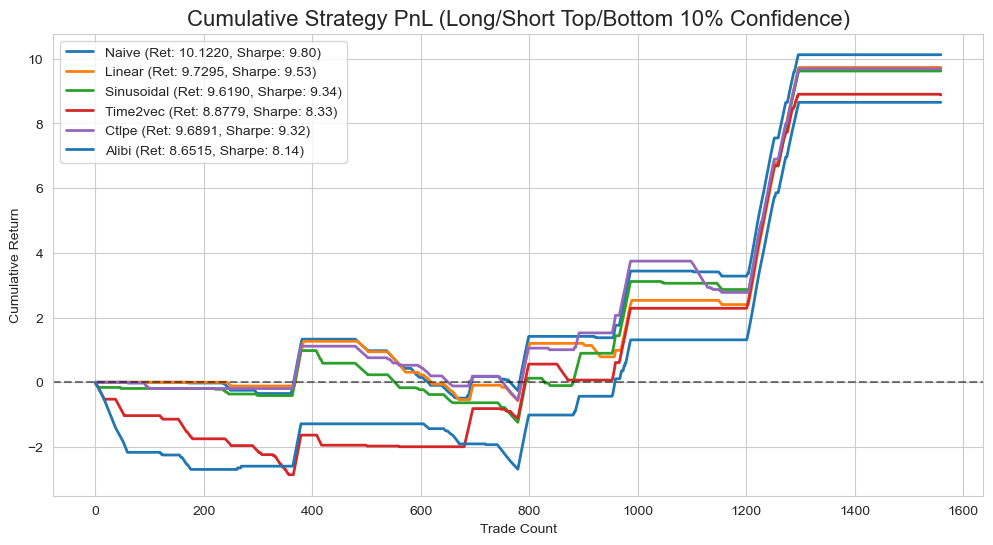

In [97]:
plt.figure(figsize=(12, 6))

# Trading Parameters
threshold_quantile = 0.90  # Trade top/bottom 10% confidence

for model in MODELS:
    if model in data_dict:
        df = data_dict[model]
        pred = df['predicted'].values
        actual = df['actual'].values
        
        # Determine thresholds
        upper = np.percentile(pred, 100 * threshold_quantile)
        lower = np.percentile(pred, 100 * (1 - threshold_quantile))
        
        # Generate signals
        signals = np.zeros_like(pred)
        signals[pred > upper] = 1
        signals[pred < lower] = -1
        
        # Strategy returns
        strategy_returns = signals * actual
        
        # Cumulative PnL
        pnl = np.cumsum(strategy_returns)
        
        # Sharpe ratio (guard against zero std)
        if np.std(strategy_returns) > 0:
            sharpe = (
                np.mean(strategy_returns)
                / np.std(strategy_returns)
                * np.sqrt(len(strategy_returns))
            )
        else:
            sharpe = np.nan
        
        # Plot
        plt.plot(
            pnl,
            label=f"{model.capitalize()} (Ret: {pnl[-1]:.4f}, Sharpe: {sharpe:.2f})",
            linewidth=2
        )

plt.title(
    f"Cumulative Strategy PnL (Long/Short Top/Bottom {100*(1-threshold_quantile):.0f}% Confidence)",
    fontsize=16
)
plt.ylabel("Cumulative Return")
plt.xlabel("Trade Count")
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

# statistical analysis

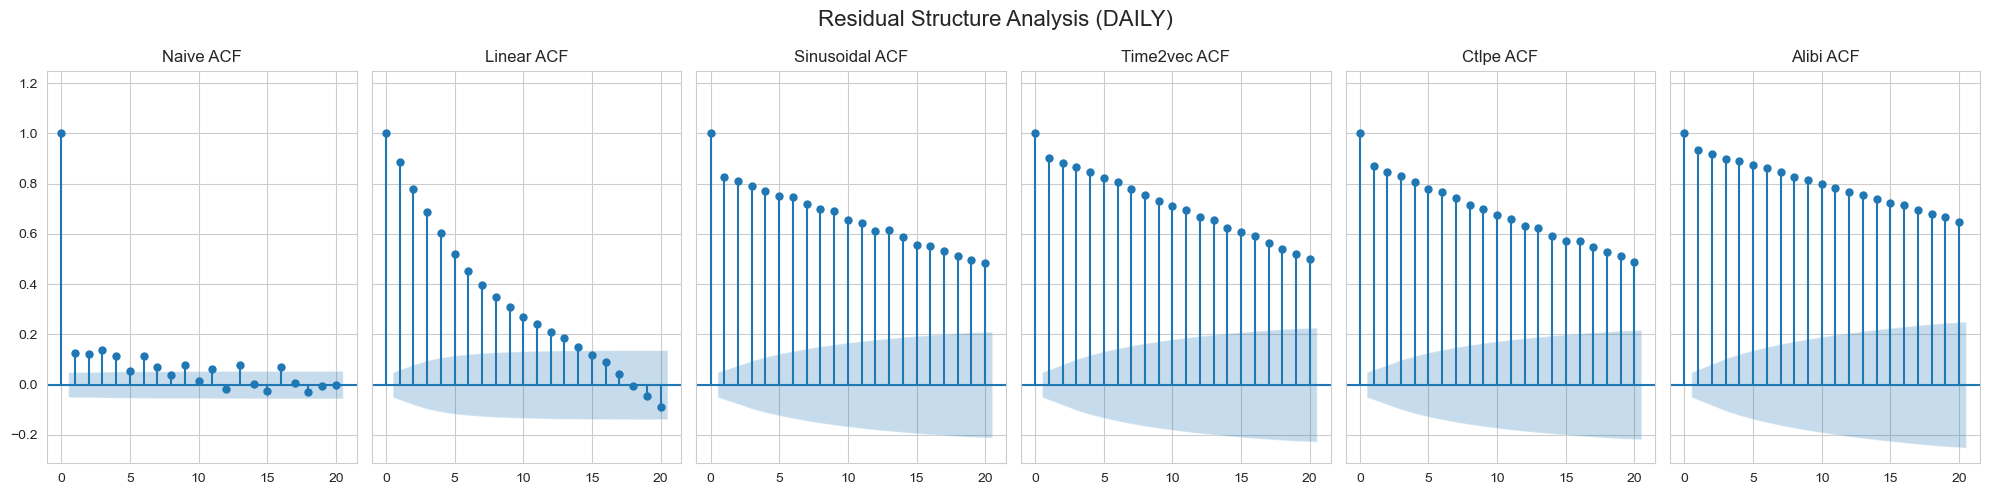


=== RESIDUAL DIAGNOSTICS (Target: p-val > 0.05, Low Kurtosis) ===


,Ljung-Box p-val,Kurtosis,Normality
Model,,,
Naive,0.000000,19.124239,Fat Tails
Linear,0.000000,4.795328,Fat Tails
Sinusoidal,0.000000,2.029578,Normal
Time2vec,0.000000,0.154139,Normal
Ctlpe,0.000000,-0.321039,Normal
Alibi,0.000000,8.048988,Fat Tails


In [98]:
if data_dict:
    # 1. ACF Plots (Grid)
    fig, axes = plt.subplots(1, len(data_dict), figsize=(20, 5), sharey=True)
    if len(data_dict) == 1: axes = [axes] # Handle single model case
    
    residual_stats = []

    for ax, (model, df) in zip(axes, data_dict.items()):
        residuals = df['actual'] - df['predicted']
        
        # Plot ACF
        plot_acf(residuals, lags=20, ax=ax, title=f"{model.capitalize()} ACF", auto_ylims=True)
        
        # Calculate Stats
        lb_pvalue = acorr_ljungbox(residuals, lags=[10])['lb_pvalue'].iloc[0]
        kurt = stats.kurtosis(residuals)
        
        residual_stats.append({
            "Model": model.capitalize(),
            "Ljung-Box p-val": lb_pvalue, 
            "Kurtosis": kurt,
            "Normality": "Normal" if kurt < 3 else "Fat Tails"
        })
    
    plt.suptitle(f"Residual Structure Analysis ({TASK.upper()})", fontsize=16)
    plt.tight_layout()
    plt.show()

    # 2. Statistical Table
    print("\n=== RESIDUAL DIAGNOSTICS (Target: p-val > 0.05, Low Kurtosis) ===")
    res_df = pd.DataFrame(residual_stats).set_index("Model")
    display(res_df.style.background_gradient(cmap="Reds", subset=["Kurtosis"]))

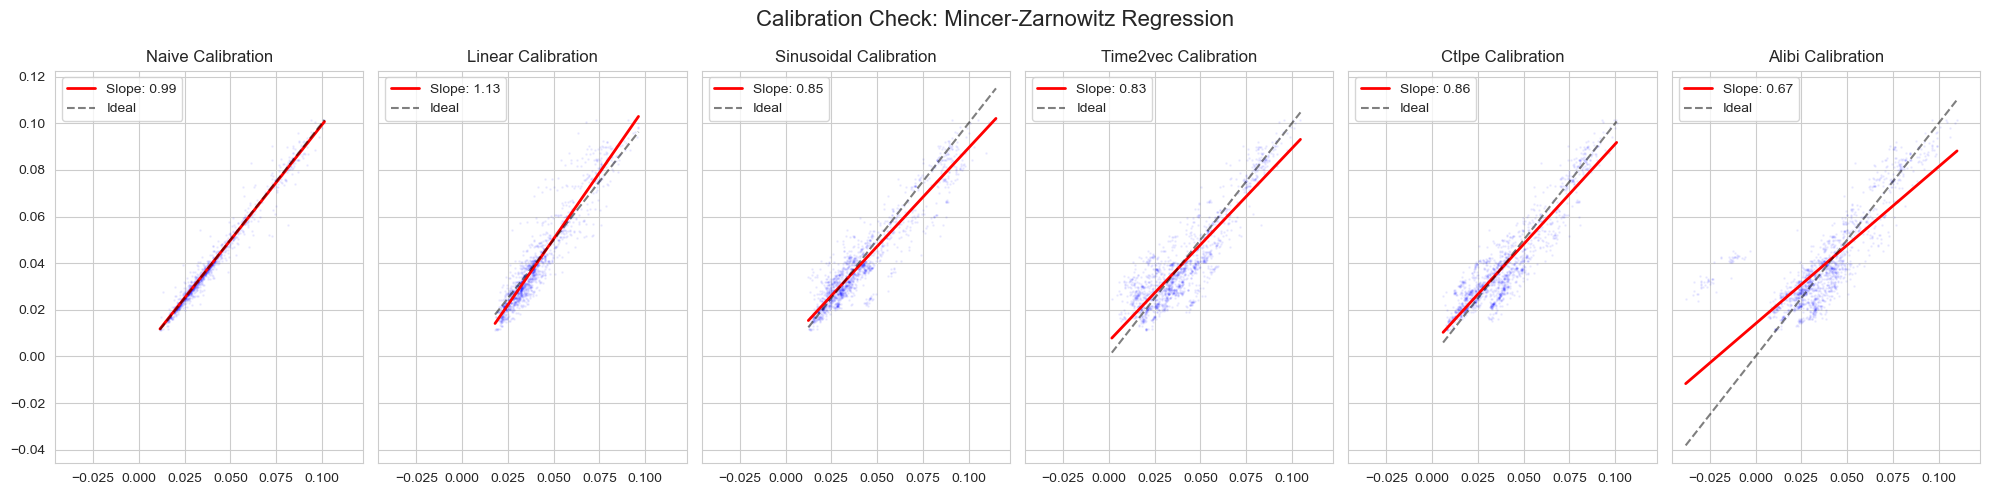


=== CALIBRATION METRICS ===


,Slope (Ideal=1),Intercept (Ideal=0),R2
Model,,,
Naive,0.989383,0.000379,0.980088
Linear,1.132952,-0.006194,0.900310
Sinusoidal,0.845622,0.004852,0.885027
Time2vec,0.826992,0.006535,0.789973
Ctlpe,0.858932,0.005222,0.847832
Alibi,0.673261,0.014025,0.641383


In [99]:
if data_dict:
    fig, axes = plt.subplots(1, len(data_dict), figsize=(20, 5), sharex=True, sharey=True)
    if len(data_dict) == 1: axes = [axes]
    
    calib_stats = []

    for ax, (model, df) in zip(axes, data_dict.items()):
        x = df['predicted']
        y = df['actual']
        
        # Linear Regression
        slope, intercept, r_val, p_val, std_err = stats.linregress(x, y)
        
        # Scatter Plot
        ax.scatter(x, y, alpha=0.05, color='blue', s=1)
        
        # Fit Line
        x_range = np.linspace(x.min(), x.max(), 100)
        ax.plot(x_range, intercept + slope * x_range, 'r-', linewidth=2, label=f'Slope: {slope:.2f}')
        
        # Ideal Line (y=x)
        ax.plot([x.min(), x.max()], [x.min(), x.max()], 'k--', alpha=0.5, label='Ideal')
        
        ax.set_title(f"{model.capitalize()} Calibration")
        ax.legend()
        
        calib_stats.append({
            "Model": model.capitalize(),
            "Slope (Ideal=1)": slope,
            "Intercept (Ideal=0)": intercept,
            "R2": r_val**2
        })

    plt.suptitle("Calibration Check: Mincer-Zarnowitz Regression", fontsize=16)
    plt.tight_layout()
    plt.show()

    print("\n=== CALIBRATION METRICS ===")
    cal_df = pd.DataFrame(calib_stats).set_index("Model")
    display(cal_df.style.bar(subset=["Slope (Ideal=1)"], align='mid', color=['#d65f5f', '#5fba7d']))

In [100]:
def diebold_mariano_test(real, pred1, pred2):
    e1 = (real - pred1)**2
    e2 = (real - pred2)**2
    d = e1 - e2
    
    # Handle zero variance (identical predictions)
    if np.std(d) == 0:
        return 0.0, 1.0
        
    dm_stat = np.mean(d) / np.sqrt(np.var(d, ddof=0) / len(d))
    p_value = 2 * (1 - stats.norm.cdf(abs(dm_stat)))
    return dm_stat, p_value

if BASELINE_MODEL in data_dict:
    dm_results = []
    base_pred = data_dict[BASELINE_MODEL]['predicted'].values
    actual = data_dict[BASELINE_MODEL]['actual'].values
    
    for model in MODELS:
        if model == BASELINE_MODEL or model not in data_dict:
            continue
            
        challenger_pred = data_dict[model]['predicted'].values
        dm, p = diebold_mariano_test(actual, base_pred, challenger_pred)
        
        # Interpretation
        if p < 0.05:
            verdict = f"✅ {model.capitalize()} Wins" if dm > 0 else f"❌ {BASELINE_MODEL.capitalize()} Wins"
        else:
            verdict = "draw (Insignificant)"
            
        dm_results.append({
            "Challenger": model.capitalize(),
            "Baseline": BASELINE_MODEL.capitalize(),
            "p-value": p,
            "Verdict": verdict
        })
        
    print(f"\n=== STATISTICAL SIGNIFICANCE (vs {BASELINE_MODEL.capitalize()}) ===")
    display(pd.DataFrame(dm_results).set_index("Challenger"))


=== STATISTICAL SIGNIFICANCE (vs Naive) ===


,Baseline,p-value,Verdict
Challenger,,,
Linear,Naive,0.0,❌ Naive Wins
Sinusoidal,Naive,0.0,❌ Naive Wins
Time2vec,Naive,0.0,❌ Naive Wins
Ctlpe,Naive,0.0,❌ Naive Wins
Alibi,Naive,0.0,❌ Naive Wins
